In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import time
from scipy.stats import laplace, norm
from scipy.optimize import curve_fit
#from scipy.stats import norm

%matplotlib inline

In [4]:
test_systems = pd.read_csv("../csvs/random/deltatimes.csv", index_col =0)
test_systems.head()


,runstring,t,t_shadow
0,0000000.bin,1.235644e+07,8.315081e+07
1,0000001.bin,1.348749e+05,2.133072e+05
2,0000002.bin,1.276381e+04,9.321519e+03
3,0000003.bin,1.000000e+09,1.000000e+09
4,0000004.bin,8.791888e+01,8.791888e+01


(189, 8)
Average Sigma 0.4504391160881758 Std in Sigma 0.1428953452166025
Max valid sigma 1.078939098463822


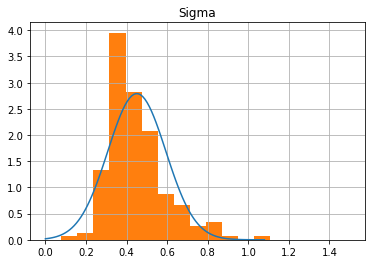

In [7]:
#pull up gaussian fits, and the P value significance, to take all systems with above 1-e6.
#this is a reasonable threshold because higher than that removes many systems, and lower than that includes many odd systems

info_frame = pd.read_csv("../csvs/random/ProbabilityTable_Fixed_Covariences_266.csv")
significances = pd.read_csv("../csvs/random/significance_scores.csv")

good_fits = significances[significances["KS_P"]>1e-6]
valid_gaus_params = info_frame[ info_frame["ID"].isin(good_fits["ID"]) ]
print(valid_gaus_params.shape)

bins = np.linspace(0, 1.5, 20)

mu_fit, sig_fit =  norm.fit(valid_gaus_params["Sigma"].values)
print("Average Sigma", mu_fit, "Std in Sigma", sig_fit)
#x, xmax = plt.xlim()
fig = plt.figure()
ax = fig.add_subplot("111")
x = np.linspace(0, valid_gaus_params["Sigma"].max(), 100)
prob_sig = norm.pdf(x, mu_fit, sig_fit)
plt.plot(x, prob_sig)
valid_gaus_params.hist("Sigma", normed = 1, ax = ax, bins = bins)
print("Max valid sigma", valid_gaus_params["Sigma"].max())

In [8]:
from scipy.stats import norm
# p is the sigma distribution

valid_delta_times = test_systems[(test_systems["t"]>1e4) 
        & (test_systems["t"]<1e7) & (test_systems["t_shadow"]>1e4)
        & (test_systems["t_shadow"]<1e7)]

norm_prob_sig = prob_sig/(prob_sig.sum())

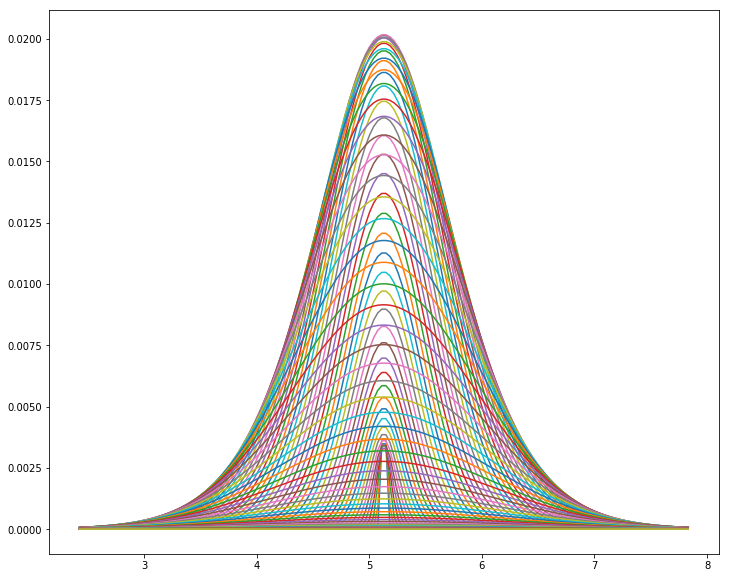

In [9]:
#Analytically over each of the mu;s, how to combine the sigmas?
#try with the first 100
trial = 10 #how many to test it with
max_sigma = mu_fit #the center, used to define bins
increments = 150 # how fine does the convoltion have to be?
#bins = np.linspace(0, 1.5, 20)

plt.figure(figsize=(12, 10))
"""
#x is whawt stores the bins values (sigma values)
#prob_sig stpres the corresponding probability of that sigma
for i in range(0, trial,1):
    total_y= np.zeros(increments)
    for j in range(1,int(prob_sig.shape[0]), 1):
        fixed_sigma=x[j]
        t_sim = np.log10(valid_delta_times["t"].values[i])
        bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)

        #print t_sim
        #p = p*prob*norm_prob_sig[j]

        final_y = norm.pdf(bins, t_sim, fixed_sigma*2**0.5)* norm_prob_sig[j]
        
        total_y +=final_y
        
        plt.plot(bins, final_y )
    break

"""


total_y= np.zeros(increments)
for j in range(1,int(prob_sig.shape[0]), 1):
    fixed_sigma=x[j]
    t_sim = np.log10(valid_delta_times["t"].values[0]) # take the first one
    # doesn't matter, the resulting shape will be the same regarless where you do it 
    bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
    final_y = norm.pdf(bins, t_sim, fixed_sigma*2**0.5)* norm_prob_sig[j]       
    total_y +=final_y
    plt.plot(bins, final_y )

end = time.time()
plt.show()


This graph is the summation of all the gaussians for ONE SYSTEM

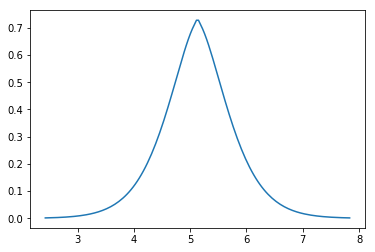

In [10]:
bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
plt.plot(bins, total_y)
width = (12*max_sigma)/(increments-1)
#print  width, bins[1] - bins[0]
#center, spread =laplace.fit(total_y)
#rv = laplace(loc = center, scale = spread)
#loc should be zero, since this should be symmetric about t = 0
# plt.plot(bins, rv.pdf(bins))
# Need to do a least sqaures fit of a laplace fit to this data

The laplace distribution has a mean of $\mu$, and a varience of $2b^2$.  P(x) = $\frac{1}{2b}exp(\frac{-|x-\mu|}{b})$

In [11]:
def laplace_fit(data, mean, spread):
    return np.exp(-np.abs(data-mean)/spread)/2./spread

How to fit laplace function to this function, needs a least sqares fit, can't use laplace fit, as that requires the individual samples

[5.12993108 0.5899713 ]
[0.00534788 0.0075827 ]
params [0.        0.5899713]


(0, 0.9)

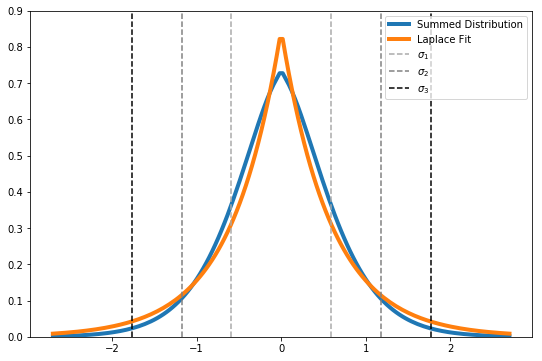

In [13]:
#function for optimizing the difference between total_Y(graph from)
#use the same x values,
plt.figure (figsize=(9, 6))
popt, pcov = curve_fit(laplace_fit, bins, total_y)
print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)

#set popt[0] to 0, since the center should be 0
# center y total as well
bins -= popt[0]
popt[0] = 0

plt.plot(bins, total_y, label = "Summed Distribution", linewidth = 4)
print("params", popt)


plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 4)


colors = ["darkgrey","grey", "black"]
for i in range(1,4):
    plt.axvline(popt[0]+i*popt[1], ls= "dashed", label = "$\sigma_{0}$".format(i), color = colors[i-1])
    plt.axvline(popt[0]-i*popt[1], ls= "dashed", color = colors[i-1])
plt.legend()
plt.ylim([0,0.9])

Now try to do this for all 5000ish systems, and save the parameters and errors. Does this even make sense, as since we are only updating the t_sim parameter for each new distribution, wouldn't all the subsequent distributions look the same, with a shift?

Try plotting all the differences once the cut is made, to see if assumptions are still valid


In [14]:
reduced_systems = test_systems[(test_systems["t"] > 1e4) &
                              (test_systems["t"] < 1e7) &
                              (test_systems["t_shadow"] > 1e4)
                              & (test_systems["t_shadow"]<1e7)]
print(reduced_systems.shape)
reduced_systems["diff"] = np.log10(reduced_systems["t"]) -np.log10(reduced_systems["t_shadow"])
reduced_systems = reduced_systems.replace([np.inf, -np.inf], np.nan)
reduced_systems = reduced_systems.dropna()
print(reduced_systems.shape)
reduced_systems.head()
print(reduced_systems["t"].max())
print(reduced_systems["t_shadow"].max())

(4825, 3)
(4825, 4)
9958284.99172
9984932.71569


/home/naireen/anaconda2/envs/CSC401/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5,1,'Delta times')

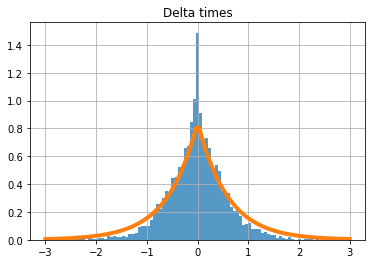

In [18]:
bins = np.linspace(-3,3,100)
reduced_systems.hist("diff", bins = bins, normed = 1, alpha = 0.75)
plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 4)
plt.title("Delta times")

This seems to match the distribution we have been getting above,that we get that double exponential shape with the differences in the simulation times of the distributions that match the same period cuts, though the estimation seems to slightly overestimate the true distribution, but that should be alright. Eliminating the really odd systems and using a gaussian fit seemed to be a better idea than using weibull fits, as the final estimated distribution overestimates significantly less